In [1]:
#imports

from __future__ import print_function
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torch.nn.parallel
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt




In [2]:
#set variables

#training options
batch_size = 128
lr_val = 0.1
start_epoch = 1
lr_decay = 0.1
optimizer_val = 'sgd' #adam 
weight_decay = 0.0005
momentum = 0.9
epochs = 300
ngpu = 1
rand_seed = 0
resume_model = ''
resume_opt = ''

#model parameters
model = 'resnet18'
loss_name = 'crossentropy'
raw_data = False
noaug = False
label_corrupt_prob = 0.0
trainloader_val = ''
testloader_val = ''
idx = 0

datatype = 'cipher10'

In [3]:
use_cuda = torch.cuda.is_available()
# print('Current devices: ' + str(torch.cuda.current_device()))
# print('Device count: ' + str(torch.cuda.device_count()))

In [4]:
def get_data_loaders(trainloader, testloader, datatype):
    if trainloader and testloader:
        assert os.path.exists(trainloader), 'trainloader does not exist'
        assert os.path.exists(testloader), 'testloader does not exist'
        trainloader = torch.load(trainloader)
        testloader = torch.load(testloader)
        return trainloader, testloader

    normalize = transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]],
                                     std=[x/255.0 for x in [63.0, 62.1, 66.7]])

    if raw_data:
        transform_train = transforms.Compose([
            transforms.ToTensor(),
        ])
    else:
        if not noaug:
            # with data augmentation
            transform_train = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                normalize,
            ])
        else:
            # no data agumentation
            transform_train = transforms.Compose([
                transforms.ToTensor(),
                normalize,
            ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])


    kwargs = {'num_workers': 2, 'pin_memory': True} if ngpu else {}

    if datatype=='cipher10':
      trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,
                                              transform=transform_train)
      testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True,
                                            transform=transform_test)

      trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                                shuffle=True, **kwargs)
      testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, **kwargs)
    else:
      trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True,
                                              transform=transform_train)
      testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True,
                                            transform=transform_test)

      trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                                shuffle=True, **kwargs)
      testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, **kwargs)

    return trainloader, testloader

In [5]:
#basicblock and resnet class

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1  = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1    = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out




# ImageNet models
def ResNet18():
  if datatype=='cipher10':
    return ResNet(BasicBlock, [2,2,2,2], 10)
  
  return ResNet(BasicBlock, [2,2,2,2], 100)





In [6]:

cfg = {
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name, num):
        super(VGG, self).__init__()
        self.input_size = 32
        self.features = self._make_layers(cfg[vgg_name])
        self.n_maps = cfg[vgg_name][-2]
        self.fc = self._make_fc_layers()
        self.classifier = nn.Linear(self.n_maps, num)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = self.classifier(out)
        return out

    def _make_fc_layers(self):
        layers = []
        layers += [nn.Linear(self.n_maps*self.input_size*self.input_size, self.n_maps),
                   nn.BatchNorm1d(self.n_maps),
                   nn.ReLU(inplace=True)]
        return nn.Sequential(*layers)

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
                self.input_size = self.input_size // 2
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        return nn.Sequential(*layers)


def VGG16():
  if datatype=='cipher10':
    return VGG('VGG16', 10)
  return VGG('VGG16', 100)



In [7]:

# map between model name and function
models = {
    'resnet18'              : ResNet18,
    'vgg16'                  : VGG16,
}


In [8]:
def load(model_name, model_file=None, data_parallel=False):
    net = models[model_name]()
    if data_parallel: # the model is saved in data paralle mode
        net = torch.nn.DataParallel(net)

    if model_file:
        assert os.path.exists(model_file), model_file + " does not exist."
        stored = torch.load(model_file, map_location=lambda storage, loc: storage)
        if 'state_dict' in stored.keys():
            net.load_state_dict(stored['state_dict'])
        else:
            net.load_state_dict(stored)

    if data_parallel: # convert the model back to the single GPU version
        net = net.module

    net.eval()
    return net

In [9]:
#initialize params; only for first training

def init_params(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            init.kaiming_normal_(m.weight, mode='fan_in')
            if m.bias is not None:
                init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant_(m.weight, 1)
            init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal_(m.weight, std=1e-3)
            if m.bias is not None:
                init.constant_(m.bias, 0)

In [10]:
# Training
def train(trainloader, net, criterion, optimizer, use_cuda=True):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    if isinstance(criterion, nn.CrossEntropyLoss):
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            batch_size = inputs.size(0)
            total += batch_size
            if use_cuda:
                inputs, targets = inputs.cuda(), targets.cuda()
            optimizer.zero_grad()
            inputs, targets = Variable(inputs), Variable(targets)
            
            
            if optimizer_val=='sgd' or optimizer_val=='adam':
              outputs = net(inputs)
              loss = criterion(outputs, targets)
              loss.backward()
              optimizer.step()
              
           

            train_loss += loss.item()*batch_size
            _, predicted = torch.max(outputs.data, 1)
            correct += predicted.eq(targets.data).cpu().sum().item()

    

    return train_loss/total, 100 - 100.*correct/total,  100.*correct/total


In [11]:
def test(testloader, net, criterion, use_cuda=True):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0

    if isinstance(criterion, nn.CrossEntropyLoss):
        for batch_idx, (inputs, targets) in enumerate(testloader):
            batch_size = inputs.size(0)
            total += batch_size

            if use_cuda:
                inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = Variable(inputs), Variable(targets)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()*batch_size
            _, predicted = torch.max(outputs.data, 1)
            correct += predicted.eq(targets.data).cpu().sum().item()

  

    return test_loss/total, 100 - 100.*correct/total,  100.*correct/total

In [12]:
def main(lr_val, start_epoch):
  random.seed(rand_seed)
  np.random.seed(rand_seed)
  torch.manual_seed(rand_seed)

  if use_cuda:
    torch.cuda.manual_seed_all(rand_seed)
    cudnn.benchmark = True

  
  

  trainloader, testloader = get_data_loaders(trainloader_val, testloader_val, datatype)



  # Model
  if resume_model:
      # Load checkpoint.
      print('==> Resuming from checkpoint..')
      checkpoint = torch.load(resume_model)
      net = load(model)
     

      net.load_state_dict(checkpoint['state_dict'])
      start_epoch = checkpoint['epoch'] + 1

  else:
      net = load(model)    

  
  if ngpu > 1:
        net = torch.nn.DataParallel(net)

  
  criterion = nn.CrossEntropyLoss()


  if use_cuda:
        net.cuda()
        criterion = criterion.cuda()

  

  # Optimizer
  if optimizer_val == 'sgd':
      optimizer = optim.SGD(net.parameters(), lr=lr_val, momentum=momentum, weight_decay=weight_decay, nesterov=True)
  elif optimizer_val=='adam':
      optimizer = optim.Adam(net.parameters(), lr=lr_val, weight_decay=weight_decay)
  


  
  if resume_opt:
    checkpoint_opt = torch.load(resume_opt)
    optimizer.load_state_dict(checkpoint_opt['optimizer'])

  

  # record the performance of initial model
  if not resume_model:
      train_loss, train_err, train_acc = test(trainloader, net, criterion, use_cuda)
      test_loss, test_err, test_acc = test(testloader, net, criterion, use_cuda)
      status = 'e: %d loss: %.5f train_err: %.3f train_acc: %.3f test_top1: %.3f test_loss %.5f test_acc: %.3f\n' % (0, train_loss, train_err, train_acc, test_err, test_loss, test_acc)
      print(status)
   
  EPOCH_LIST = []
  TRAIN_ACC_LIST = []
  TEST_ACC_LIST = []
  for epoch in range(start_epoch, epochs + 1):
        EPOCH_LIST.append(epoch)
        loss, train_err, train_acc = train(trainloader, net, criterion, optimizer, use_cuda)
        TRAIN_ACC_LIST.append(train_acc)
        test_loss, test_err, test_acc = test(testloader, net, criterion, use_cuda)
        TEST_ACC_LIST.append(test_acc)
        status = 'e: %d loss: %.5f train_err: %.3f train_acc: %.3f test_top1: %.3f test_loss %.5f test_acc: %.3f\n' % (epoch, loss, train_err, train_acc, test_err, test_loss, test_acc)
        print(status)
       

        if int(epoch) == 150 or int(epoch) == 225 or int(epoch) == 275:
            lr_val *= lr_decay
            for param_group in optimizer.param_groups:
                param_group['lr'] *= lr_decay

  torch.save(net.state_dict(),'model_'+model+"_"+datatype+"_"+optimizer_val+"_" '.pt')

  return EPOCH_LIST, TRAIN_ACC_LIST, TEST_ACC_LIST



In [13]:
def plot(EPOCH_LIST, TRAIN_ACC_LIST, TEST_ACC_LIST):
  plt.plot(EPOCH_LIST, TRAIN_ACC_LIST, label='train')
  plt.plot(EPOCH_LIST, TEST_ACC_LIST, label='test')
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.legend(loc='best')
  plt.show()

In [ ]:
EPOCH_LIST, TRAIN_ACC_LIST, TEST_ACC_LIST = main(lr_val, start_epoch)

Files already downloaded and verified
Files already downloaded and verified
e: 0 loss: 2.30271 train_err: 89.748 train_acc: 10.252 test_top1: 89.390 test_loss 2.30278 test_acc: 10.610

e: 1 loss: 1.95361 train_err: 68.602 train_acc: 31.398 test_top1: 58.430 test_loss 1.56835 test_acc: 41.570

e: 2 loss: 1.47909 train_err: 54.330 train_acc: 45.670 test_top1: 50.450 test_loss 1.42110 test_acc: 49.550

e: 3 loss: 1.19206 train_err: 42.722 train_acc: 57.278 test_top1: 40.750 test_loss 1.16173 test_acc: 59.250

e: 4 loss: 0.97332 train_err: 34.474 train_acc: 65.526 test_top1: 44.520 test_loss 1.42416 test_acc: 55.480

e: 5 loss: 0.83036 train_err: 29.452 train_acc: 70.548 test_top1: 27.620 test_loss 0.79036 test_acc: 72.380

e: 6 loss: 0.70387 train_err: 24.652 train_acc: 75.348 test_top1: 25.650 test_loss 0.76711 test_acc: 74.350

e: 7 loss: 0.61184 train_err: 21.316 train_acc: 78.684 test_top1: 21.980 test_loss 0.63028 test_acc: 78.020

e: 8 loss: 0.55393 train_err: 19.168 train_acc: 80.8

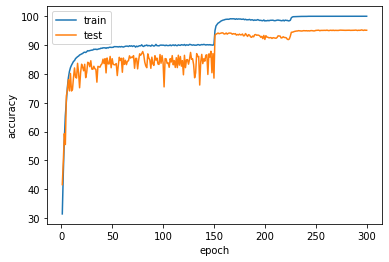

In [ ]:
plot(EPOCH_LIST, TRAIN_ACC_LIST, TEST_ACC_LIST)

In [ ]:
optimizer_val = 'adam'
EPOCH_LIST, TRAIN_ACC_LIST, TEST_ACC_LIST = main(lr_val, start_epoch)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
e: 0 loss: 2.30271 train_err: 89.748 train_acc: 10.252 test_top1: 89.390 test_loss 2.30278 test_acc: 10.610

e: 1 loss: 2.22386 train_err: 77.128 train_acc: 22.872 test_top1: 82.850 test_loss 2.40879 test_acc: 17.150

e: 2 loss: 1.83520 train_err: 70.552 train_acc: 29.448 test_top1: 75.030 test_loss 2.05760 test_acc: 24.970

e: 3 loss: 1.82933 train_err: 70.488 train_acc: 29.512 test_top1: 82.670 test_loss 4.69762 test_acc: 17.330

e: 4 loss: 1.82238 train_err: 70.056 train_acc: 29.944 test_top1: 74.350 test_loss 1.90460 test_acc: 25.650

e: 5 loss: 1.81695 train_err: 70.000 train_acc: 30.000 test_top1: 77.460 test_loss 2.87824 test_acc: 22.540

e: 6 loss: 1.81847 train_err: 70.462 train_acc: 29.538 test_top1: 76.990 test_loss 4.71491 test_acc: 23.010

e: 7 loss: 1.81907 train_err: 69.838 train_acc: 30.162 test_top1: 78.690 test_loss 2.70977 test_acc: 21.310

e: 8 loss: 1.82058 train_err: 70.182 tr

In [ ]:
plot(EPOCH_LIST, TRAIN_ACC_LIST, TEST_ACC_LIST)

In [ ]:
#change model
model = 'vgg16'


In [ ]:
optimizer_val = 'sgd'
EPOCH_LIST, TRAIN_ACC_LIST, TEST_ACC_LIST = main(lr_val, start_epoch)

In [ ]:
plot(EPOCH_LIST, TRAIN_ACC_LIST, TEST_ACC_LIST)

In [ ]:
optimizer_val = 'adam'
EPOCH_LIST, TRAIN_ACC_LIST, TEST_ACC_LIST = main(lr_val, start_epoch)

In [ ]:
plot(EPOCH_LIST, TRAIN_ACC_LIST, TEST_ACC_LIST)

In [ ]:
#CHANGE TO CIPHER100

datatype = 'cipher100'

In [ ]:
#change model
model = 'resnet18'

In [ ]:
optimizer_val = 'sgd'
EPOCH_LIST, TRAIN_ACC_LIST, TEST_ACC_LIST = main(lr_val, start_epoch)

In [ ]:
plot(EPOCH_LIST, TRAIN_ACC_LIST, TEST_ACC_LIST)

In [ ]:
optimizer_val = 'adam'
EPOCH_LIST, TRAIN_ACC_LIST, TEST_ACC_LIST = main(lr_val, start_epoch)

In [ ]:
plot(EPOCH_LIST, TRAIN_ACC_LIST, TEST_ACC_LIST)

In [ ]:
#change model
model = 'vgg16'


In [ ]:
optimizer_val = 'sgd'
EPOCH_LIST, TRAIN_ACC_LIST, TEST_ACC_LIST = main(lr_val, start_epoch)

In [ ]:
plot(EPOCH_LIST, TRAIN_ACC_LIST, TEST_ACC_LIST)

In [ ]:
optimizer_val = 'adam'
EPOCH_LIST, TRAIN_ACC_LIST, TEST_ACC_LIST = main(lr_val, start_epoch)

In [ ]:
plot(EPOCH_LIST, TRAIN_ACC_LIST, TEST_ACC_LIST)